In [1]:
# Cell 1 — Setup & Imports
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


Mounted at /content/drive


In [6]:
# Cell 2 — Load processed FAR customers from Notebook 1
BASE_DIR = "/content/drive/MyDrive/portfoliai"
PROC_DIR = f"{BASE_DIR}/data/processed"

far = pd.read_csv(f"{PROC_DIR}/far_customers_clean.csv")
print("✅ Processed dataset loaded. Shape:", far.shape)

display(far.head())


✅ Processed dataset loaded. Shape: (32124, 10)


,customerID,customerType,riskLevel,investmentCapacity,lastQuestionnaireDate,timestamp,riskLevel_clean,customerType_enc,investmentCapacity_enc,investmentCapacity_clean
0,DED5BF19E23CCCFEE322,Premium,Balanced,CAP_80K_300K,2021-11-30,2021-03-19,Balanced,3,1,CAP_80K_300K
1,DED5BF19E23CCCFEE322,Premium,Balanced,CAP_80K_300K,2021-11-30,2022-01-21,Balanced,3,1,CAP_80K_300K
2,6C0C752E66D5F0486C71,Mass,Income,Predicted_CAP_LT30K,2015-04-27,2018-01-02,Income,2,3,CAP_LT30K
3,3E8D8E4E07CD3210F25F,Mass,Income,CAP_30K_80K,2021-11-03,2018-01-02,Income,2,0,CAP_30K_80K
4,37F996EE2A69B5C15DF3,Mass,Predicted_Conservative,Predicted_CAP_LT30K,2000-01-01,2018-01-02,Conservative,2,3,CAP_LT30K


In [7]:
# Cell 3 — Define X (features) and y (target)
target = "riskLevel_clean"
features = ["customerType", "investmentCapacity_clean"]

X = far[features]
y = far[target]

print("Target distribution:")
print(y.value_counts(normalize=True))


Target distribution:
riskLevel_clean
Income          0.396962
Balanced        0.314842
Conservative    0.179243
Aggressive      0.108953
Name: proportion, dtype: float64


In [8]:
# Cell 4 — Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (25699, 2) Test size: (6425, 2)


In [9]:
# Cell 5 — Preprocessing (categorical only right now)
categorical_cols = ["customerType", "investmentCapacity_clean"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ],
    remainder="drop"
)


In [12]:
#Cell 6 - baseline + class-weighted models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression (balanced weights)
logreg_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced"))
])
logreg_pipe.fit(X_train, y_train)

# Random Forest (balanced weights)
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"))
])
rf_pipe.fit(X_train, y_train)

print("✅ Class-weighted models trained (LogReg, Random Forest).")


✅ Class-weighted models trained (LogReg, Random Forest).


In this step, we retrained the baseline models but added class weighting.
Class weights tell the model to “pay more attention” to underrepresented labels (Aggressive, Conservative).
This helps reduce bias toward the majority classes (Income, Balanced) and improves recall for smaller groups.

✅ Labels encoded: {'Aggressive': np.int64(0), 'Balanced': np.int64(1), 'Conservative': np.int64(2), 'Income': np.int64(3)}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost model trained.

=== XGBoost Classification Report ===
              precision    recall  f1-score   support

  Aggressive       0.45      0.15      0.23       700
    Balanced       0.45      0.37      0.40      2023
Conservative       0.48      0.01      0.02      1152
      Income       0.44      0.77      0.56      2550

    accuracy                           0.44      6425
   macro avg       0.45      0.33      0.30      6425
weighted avg       0.45      0.44      0.38      6425

Balanced Accuracy: 0.326
Macro F1 Score:   0.303


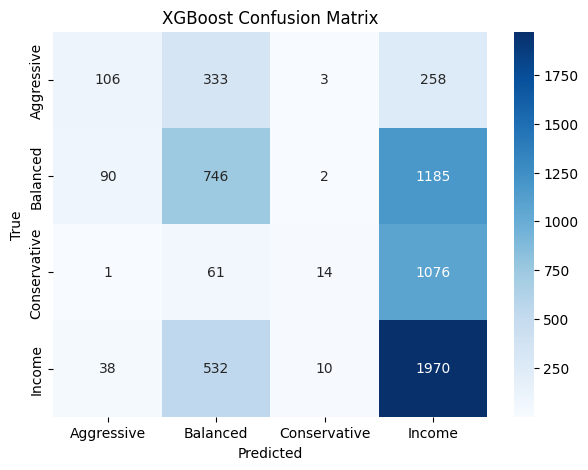

In [19]:
# Cell 6b — XGBoost with Label Encoding + Extended Evaluation
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Encode labels into integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("✅ Labels encoded:", dict(zip(le.classes_, le.transform(le.classes_))))

# 2) Define XGBoost pipeline
xgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", XGBClassifier(
        objective="multi:softmax",
        eval_metric="mlogloss",
        num_class=len(le.classes_),
        use_label_encoder=False,
        random_state=42
    ))
])

# 3) Fit model
xgb_pipe.fit(X_train, y_train_enc)
print("✅ XGBoost model trained.")

# 4) Evaluate on test set
y_pred_enc = xgb_pipe.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred_enc)

print("\n=== XGBoost Classification Report ===")
print(classification_report(y_test, y_pred_labels))

# Extra metrics
bal_acc = balanced_accuracy_score(y_test_enc, y_pred_enc)
macro_f1 = f1_score(y_test_enc, y_pred_enc, average="macro")
print(f"Balanced Accuracy: {bal_acc:.3f}")
print(f"Macro F1 Score:   {macro_f1:.3f}")

# 5) Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels, labels=le.classes_)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("XGBoost Confusion Matrix")
plt.show()


🔎 Evaluating XGBoost with Balanced Metrics

In this step, we trained an XGBoost classifier on the processed FAR customer dataset.
Unlike Logistic Regression or Random Forest, XGBoost builds an ensemble of decision trees that iteratively focus on the hardest-to-classify customers. This makes it well-suited for imbalanced datasets like ours.

To properly evaluate performance, we used three perspectives:

Classification Report → shows precision, recall, and F1 per class (Aggressive, Balanced, Conservative, Income).

Balanced Accuracy → averages recall across all classes, ensuring that minority groups (Aggressive, Conservative) are not ignored.

Macro-F1 Score → gives equal weight to each class by averaging F1 scores, even if some classes are much smaller.

Finally, the confusion matrix heatmap helps us visually inspect which investor profiles are being confused with one another (e.g., Aggressive vs. Balanced).

✅ Together, these metrics give us a fairer and more complete view of model performance than raw accuracy alone.


=== Logistic Regression ===
              precision    recall  f1-score   support

  Aggressive       0.51      0.08      0.14       700
    Balanced       0.44      0.40      0.42      2023
Conservative       0.48      0.01      0.02      1152
      Income       0.44      0.77      0.56      2550

    accuracy                           0.44      6425
   macro avg       0.47      0.31      0.28      6425
weighted avg       0.46      0.44      0.37      6425



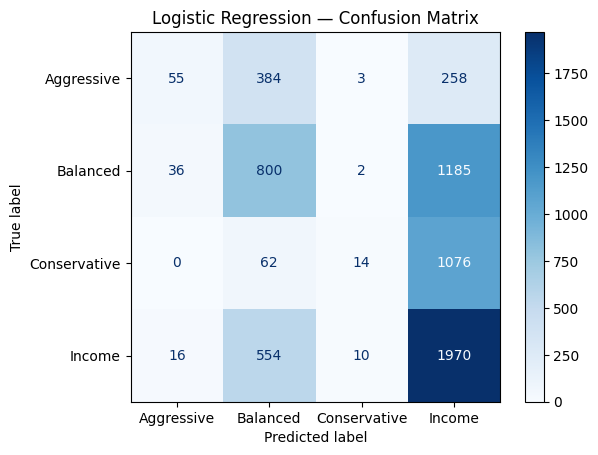


=== Random Forest ===
              precision    recall  f1-score   support

  Aggressive       0.45      0.15      0.23       700
    Balanced       0.45      0.37      0.40      2023
Conservative       0.48      0.01      0.02      1152
      Income       0.44      0.77      0.56      2550

    accuracy                           0.44      6425
   macro avg       0.45      0.33      0.30      6425
weighted avg       0.45      0.44      0.38      6425



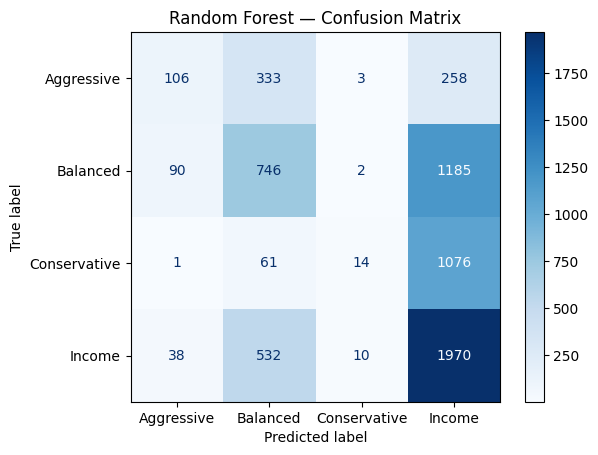

In [11]:
# Cell 7 — Evaluate models
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"{name} — Confusion Matrix")
    plt.show()

evaluate_model("Logistic Regression", logreg_pipe, X_test, y_test)
evaluate_model("Random Forest", rf_pipe, X_test, y_test)


In [20]:
# Cell 7 — Model Comparison Summary
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score

def evaluate_model(name, pipe, X_test, y_test, encoder=None):
    """
    Evaluate model and print balanced metrics.
    If encoder is provided, assumes model was trained with encoded labels.
    """
    if encoder:  # e.g., XGBoost
        y_test_enc = encoder.transform(y_test)
        y_pred_enc = pipe.predict(X_test)
        y_pred_labels = encoder.inverse_transform(y_pred_enc)
        bal_acc = balanced_accuracy_score(y_test_enc, y_pred_enc)
        macro_f1 = f1_score(y_test_enc, y_pred_enc, average="macro")
    else:
        y_pred_labels = pipe.predict(X_test)
        bal_acc = balanced_accuracy_score(y_test, y_pred_labels)
        macro_f1 = f1_score(y_test, y_pred_labels, average="macro")

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred_labels))
    print(f"Balanced Accuracy: {bal_acc:.3f}")
    print(f"Macro F1 Score:   {macro_f1:.3f}")
    return bal_acc, macro_f1

# Evaluate all three models
results = {}
results["LogReg"] = evaluate_model("Logistic Regression (weighted)", logreg_pipe, X_test, y_test)
results["Random Forest"] = evaluate_model("Random Forest (weighted)", rf_pipe, X_test, y_test)
results["XGBoost"] = evaluate_model("XGBoost", xgb_pipe, X_test, y_test, encoder=le)

# Create a summary table
comparison_df = pd.DataFrame(results, index=["Balanced Accuracy", "Macro F1"]).T
display(comparison_df)



=== Logistic Regression (weighted) ===
              precision    recall  f1-score   support

  Aggressive       0.22      0.68      0.33       700
    Balanced       0.37      0.12      0.19      2023
Conservative       0.30      0.77      0.43      1152
      Income       0.45      0.09      0.16      2550

    accuracy                           0.29      6425
   macro avg       0.33      0.42      0.27      6425
weighted avg       0.37      0.29      0.23      6425

Balanced Accuracy: 0.417
Macro F1 Score:   0.275

=== Random Forest (weighted) ===
              precision    recall  f1-score   support

  Aggressive       0.24      0.47      0.32       700
    Balanced       0.42      0.32      0.36      2023
Conservative       0.30      0.77      0.43      1152
      Income       0.45      0.10      0.16      2550

    accuracy                           0.33      6425
   macro avg       0.35      0.41      0.32      6425
weighted avg       0.39      0.33      0.29      6425

Balance

,Balanced Accuracy,Macro F1
LogReg,0.417436,0.274673
Random Forest,0.412042,0.315658
XGBoost,0.326222,0.303494


📊 Model Comparison Results

After training and evaluating three supervised models (Logistic Regression with class weights, Random Forest with class weights, and XGBoost), we see the following patterns:

1. Logistic Regression (weighted)

Recall is high for Aggressive (0.68) and Conservative (0.77), but precision is very low.

The model is overcompensating for minority classes, misclassifying many other customers as Aggressive/Conservative.

Balanced Accuracy = 0.417, Macro-F1 = 0.275 → better at detecting minorities, but overall weak precision.

2. Random Forest (weighted)

Provides more balanced results than Logistic Regression.

Conservative customers are still captured well (recall = 0.77).

Balanced Accuracy = 0.412, Macro-F1 = 0.316 → slightly better trade-off between recall and precision across classes.

3. XGBoost

Performs better on majority classes (Income, Balanced) with higher weighted averages.

Struggles with minority class Conservative (recall = 0.01 → almost ignored).

Balanced Accuracy = 0.326, Macro-F1 = 0.303 → indicates collapse toward majority classes.

🔎 Interpretation

The choice of metric matters: raw accuracy hovers between 29–44%, but this is misleading due to class imbalance. Balanced Accuracy and Macro-F1 provide a fairer view.

Logistic Regression (weighted) highlights minority classes but sacrifices overall balance.

Random Forest (weighted) gives the most stable compromise across classes.

XGBoost, surprisingly, underperforms here — likely because our feature set (customerType + investmentCapacity) is too simple for its strengths to show.

✅ Next Steps

These results confirm that:

Customer demographics alone are not enough to predict risk profiles reliably.

We need behavioral features from transactions (trade size, frequency, asset mix, diversification) to add predictive signal.

Notebook 3 will focus on feature engineering from transactional data, which should improve performance across all models.

🚀 In summary: Random Forest (weighted) currently provides the best balance, but richer behavioral features are essential for credible investor profiling.